In [1]:
import numpy as np
from numpy._typing import NDArray
import pandas as pd

### Bring a data sample

In [2]:
df: pd.DataFrame = pd.read_csv("data/mars/test/data/XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.csv", parse_dates = ['time(%Y-%m-%dT%H:%M:%S.%f)'], index_col = ['time(%Y-%m-%dT%H:%M:%S.%f)'])
df.columns = ['time', 'v']

In [3]:
df

,time,v
time(%Y-%m-%dT%H:%M:%S.%f),,
2019-05-23 02:00:00.032,0.00,-0.000000
2019-05-23 02:00:00.082,0.05,0.000199
2019-05-23 02:00:00.132,0.10,-0.001630
2019-05-23 02:00:00.182,0.15,-0.000875
2019-05-23 02:00:00.232,0.20,-0.006137
...,...,...
2019-05-23 02:59:59.782,3599.75,0.000580
2019-05-23 02:59:59.832,3599.80,0.000412
2019-05-23 02:59:59.882,3599.85,0.000985


In [4]:
time: NDArray = df['time'].resample('s').mean().values
v: NDArray = df['v'].resample('s').mean().values

#### Visualizing the raw dat

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

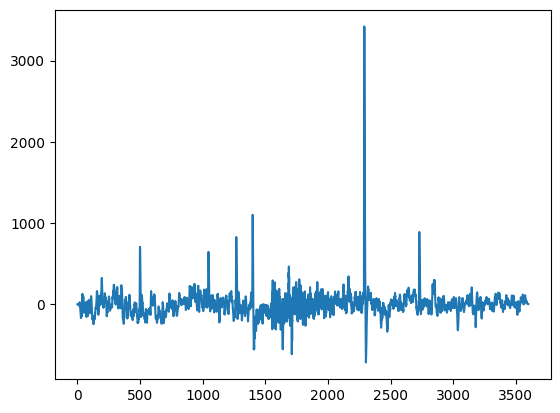

In [6]:
plt.plot(
    time,
    v
)
plt.show()

## Analysing the waves through fourier analysis

In [7]:
from numpy.fft import fft
from sklearn.preprocessing import StandardScaler
freqs: NDArray = np.abs(fft(v))
normed_freqs: NDArray = StandardScaler().fit_transform(freqs.reshape(-1, 1)).reshape(-1)

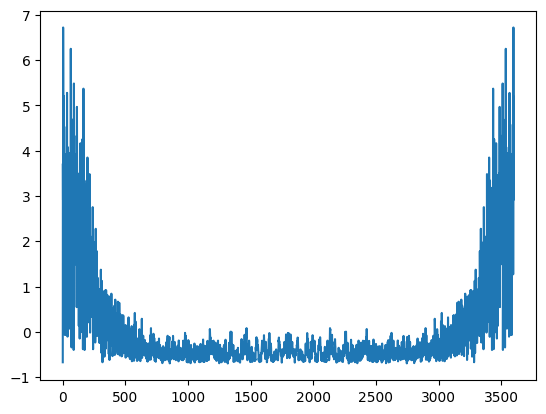

In [8]:
plt.plot(
    time,
    normed_freqs
)
plt.show()

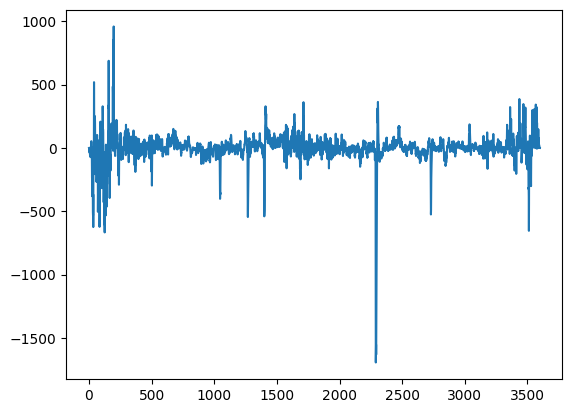

In [9]:
hadamard: NDArray = v * normed_freqs
plt.plot(
    time,
    hadamard
)

## Applying gaussian filters to the data

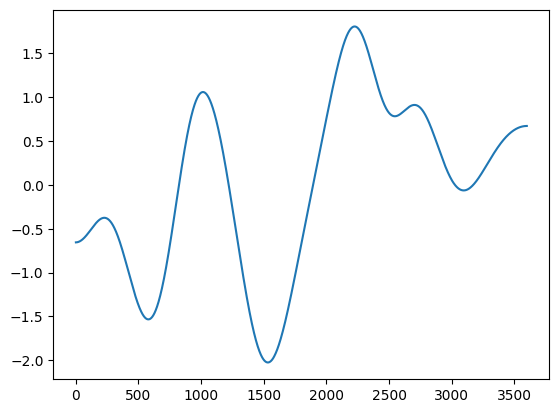

In [10]:
from scipy.ndimage import gaussian_filter
filtered: NDArray = gaussian_filter(v, sigma = v.std())
normed_filtered:NDArray = StandardScaler().fit_transform(filtered.reshape(-1, 1)).reshape(-1)
plt.plot(
    time,
    normed_filtered
)

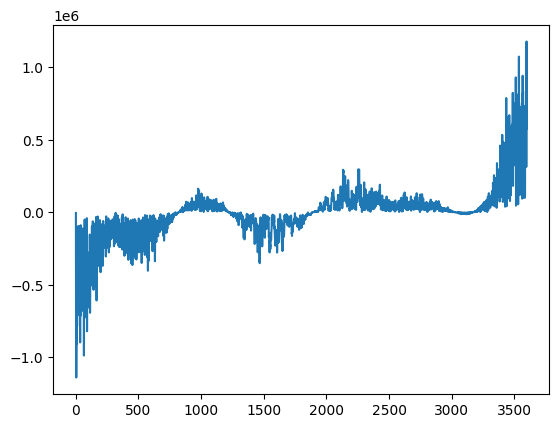

In [11]:
plt.plot(
    time,
    filtered * freqs
)